In [ ]:
!pip install sklearn

     |████████████████████████████████| 24.9 MB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 74.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=2fd7e58442a1c424caea62eda204f3385305ceafd3d32ab978d1d72d5f995fb2
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [177]:
### Environment setup
import sys
sys.path.append('/content')
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd
from pystac_client import Client
import planetary_computer as pc
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
    
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

### Load the data

#d = pd.read_csv("https://donaldpinckney.com/books/pytorch/book/ch2-linreg/code/linreg-multi-synthetic-2.csv", header=None)
d = pd.read_csv("az://modeling-data/fluvius_data.csv", storage_options=storage_options)
d = d[d['Chip Cloud Pct']<20]
ds = d[['sentinel-2-l2a_R','sentinel-2-l2a_G','sentinel-2-l2a_B','julian_date','SSC (mg/L)']]
dims = 4

X = ds.values[:,:dims].T
y = np.expand_dims(ds.values[:,dims], axis=0)
_X_train, _X_test, _y_train, _y_test = train_test_split(X.T, y.T, test_size=0.1, random_state=1337)

X_train = torch.tensor(_X_train.T, dtype=torch.float)
y_train = torch.tensor(_y_train.T, dtype=torch.float)
X_test = torch.tensor(_X_test.T, dtype=torch.float)
y_test = torch.tensor(_y_test.T, dtype=torch.float)

### Feature Scaling computations

# Pre-compute the means and standard deviations of independent variables
means = X_train.mean(1, keepdim=True)
deviations = X_train.std(1, keepdim=True)


In [220]:
ds

,sentinel-2-l2a_R,sentinel-2-l2a_G,sentinel-2-l2a_B,julian_date,SSC (mg/L)
0,49.656682,47.092166,39.410138,282,4.8
1,79.961310,91.555736,64.028950,269,1.5
2,60.305261,90.178330,62.198118,93,244.2
3,45.599346,58.495724,34.121479,211,1.5
4,16.975336,20.751121,15.405830,199,1.1
...,...,...,...,...,...
4411,54.433566,43.864802,33.650350,138,45.0
4413,65.988602,57.739252,43.110778,183,7.7
4414,35.092317,29.657993,18.603470,118,870.0
4417,70.079439,59.373164,43.405874,168,63.0


In [233]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()
from bokeh.layouts import row
# create a new plot
s1 = figure(width=250, plot_height=250)
s1.xaxis.axis_label = 'sentinel-2-l2a_R'
s1.yaxis.axis_label = 'SSC (mg/L)'
s1.circle(x='sentinel-2-l2a_R', y='SSC (mg/L)', \
          size=2, color="firebrick", alpha=0.5,\
          source=ds)
s1.add_tools(HoverTool(
    tooltips=[
        ('reflectance','@{sentinel-2-l2a_R}'),\
        ('ssc','@{SSC (mg/L)}'),]))
# create another one
s2 = figure(width=250, height=250)
s2.xaxis.axis_label = 'sentinel-2-l2a_G'
s2.yaxis.axis_label = 'SSC (mg/L)'
s2.triangle(x='sentinel-2-l2a_G', y='SSC (mg/L)', \
            size=2, color="green", alpha=0.5,\
            source=ds)
s2.add_tools(HoverTool(
    tooltips=[
        ('reflectance','@{sentinel-2-l2a_G}'),\
        ('ssc','@{SSC (mg/L)}'),]))
# create and another
s3 = figure(width=250, height=250)
s3.xaxis.axis_label = 'sentinel-2-l2a_B'
s3.yaxis.axis_label = 'SSC (mg/L)'
s3.square(x='sentinel-2-l2a_B', y='SSC (mg/L)', \
          size=2, color="navy", alpha=0.5,\
          source=ds)
s3.add_tools(HoverTool(
    tooltips=[
        ('reflectance','@{sentinel-2-l2a_B}'),\
        ('ssc','@{SSC (mg/L)}'),]))
# show the results in a row
show(row(s1, s2, s3))

Loading BokehJS ...

In [ ]:

### Model definition ###

# First we define the trainable parameters A and b 
A = torch.randn((1, dims), requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Then we define the prediction model
#def model(x_input):
#    return A.mm(x_input) + b

### Custom prediction model ###
def model(x_input):
    x_transformed = (x_input - means) / deviations
    return A.mm(x_transformed) + b

#standard model
#in_features = n # number of independent variables
#out_features = 1 # dimension of predicted variables
# bias is default true and can be skipped
#model = torch.nn.Linear(in_features=in_features, out_features=out_features, bias=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

### Custom Loss function definition ###
#def loss(y_predicted, y_target):
#    return ((y_predicted - y_target)**2).sum()
mse_loss = torch.nn.MSELoss()
### Training the model ###

# Setup the optimizer object, so it optimizes a and b.
optimizer = optim.Adam([A, b], lr=0.01)

# Main optimization loop
loss_list = []
r2_list = []
epochs = 30000
train_loss = np.zeros(epochs)
train_acc = np.zeros(epochs)
test_loss = np.zeros(epochs)
test_acc = np.zeros(epochs)

for t in tqdm(range(epochs)):
    # Set the gradients to 0.
    optimizer.zero_grad()
    # Compute the current predicted y's from x_dataset
    y_predicted = model(X_train)
    y_predicted_test = model(X_test)
    # See how far off the prediction is
    current_loss = mse_loss(y_predicted, y_train)
    train_loss[t] = current_loss
    test_loss[t] = mse_loss(y_predicted_test, y_test)
    
    train_acc[t] = r2_score(y_true=y_train.numpy()[0],\
         y_pred=y_predicted.detach().numpy()[0])
    test_acc[t] = r2_score(y_true=y_test.numpy()[0],\
         y_pred=y_predicted_test.detach().numpy()[0])
    # Compute the gradient of the loss with respect to A and b.
    current_loss.backward()
    # Update A and b accordingly.
    optimizer.step()
    #print(f"t = {t}, loss = {current_loss}, A = {A.detach().numpy()}, b = {b.item()}")

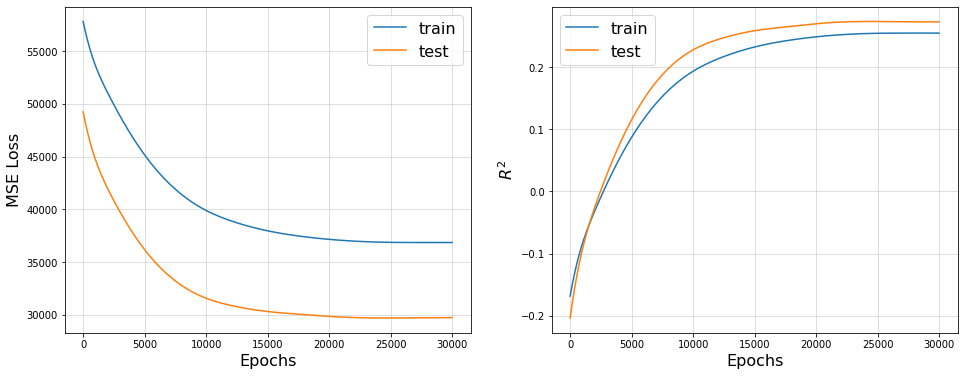

In [195]:
f, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(np.arange(epochs),train_loss, label='train')
ax[0].plot(np.arange(epochs),test_loss, label='test')
ax[1].plot(np.arange(epochs),train_acc, label='train')
ax[1].plot(np.arange(epochs),test_acc, label='test')
ax[0].set_ylabel('MSE Loss', fontsize=16)
ax[1].set_ylabel('$R^{2}$', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)